# Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [4]:
from sklearn.metrics import (
    accuracy_score,              
    confusion_matrix,           
    roc_auc_score,                
    roc_curve,                   
    precision_score,             
    recall_score,                
    f1_score,           
    auc,
classification_report,

)

### Load Dataset

In [5]:
# Download Dataset from here : https://www.kaggle.com/datasets/drnimishadavis/customer-churn-dataset
data=pd.read_csv('Dataset/customer churn dataset.csv',nrows=50000)
data.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668,33.0,3,0.00,2,1,0,181449.97,0,...,1,0,0,0,1,0,0,0,"9.090.909.090.909.090,00",99.0
1,2024,627,33.0,1,0.00,2,1,1,49503.50,0,...,1,0,0,0,1,2,0,0,"30.303.030.303.030.300,00",33.0
2,1236,678,40.0,10,0.00,2,1,0,184866.69,0,...,1,0,0,0,1,0,0,0,0.25,400.0
3,1362,581,34.0,2,148882.54,1,1,1,84560.88,0,...,1,0,0,0,1,1,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716,33.0,5,0.00,2,1,1,15068.83,0,...,0,0,1,0,1,2,0,0,"15.151.515.151.515.100,00",165.0


### Preprocessing

In [6]:
data.isna().sum()

Surname               0
CreditScore           0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Surname_tfidf_0       0
Surname_tfidf_1       0
Surname_tfidf_2       0
Surname_tfidf_3       0
Surname_tfidf_4       0
France                0
Germany               0
Spain                 0
Female                0
Male                  0
Mem__no__Products     0
Cred_Bal_Sal          0
Bal_sal               0
Tenure_Age            0
Age_Tenure_product    0
dtype: int64

In [6]:
data.duplicated().sum()

7

In [7]:
data=data.drop_duplicates()

In [8]:
data.duplicated().sum()

0

In [9]:
data['EstimatedSalary'] = pd.to_numeric(data['EstimatedSalary'], errors='coerce')

In [10]:
label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [11]:
drop_columns = ['Surname'] + [f'Surname_tfidf_{i}' for i in range(5)]
data.drop(columns=drop_columns, inplace=True)

In [12]:
data.dtypes

CreditScore             int64
Age                   float64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
France                  int64
Germany                 int64
Spain                   int64
Female                  int64
Male                    int64
Mem__no__Products       int64
Cred_Bal_Sal            int32
Bal_sal                 int32
Tenure_Age              int32
Age_Tenure_product    float64
dtype: object

In [13]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,668,33.0,3,0.00,2,1,0,181449.97,0,1,0,0,0,1,0,0,0,351,99.0
1,627,33.0,1,0.00,2,1,1,49503.50,0,1,0,0,0,1,2,0,0,242,33.0
2,678,40.0,10,0.00,2,1,0,184866.69,0,1,0,0,0,1,0,0,0,14,400.0
3,581,34.0,2,148882.54,1,1,1,84560.88,0,1,0,0,0,1,1,1138,6961,296,68.0
4,716,33.0,5,0.00,2,1,1,15068.83,0,0,0,1,0,1,2,0,0,127,165.0


### Outlier detection and handling

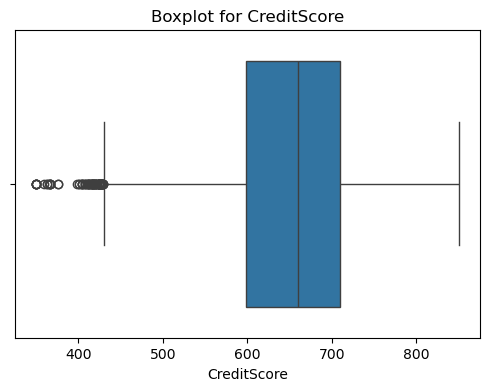

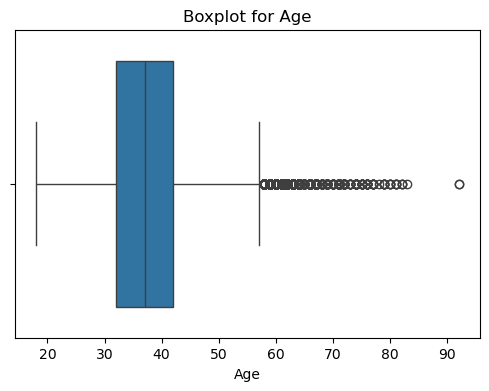

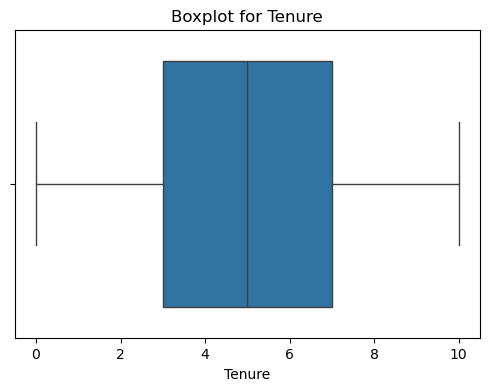

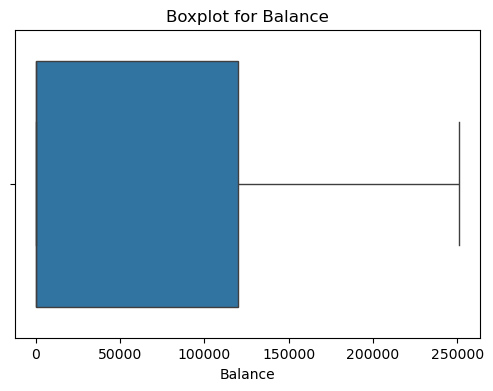

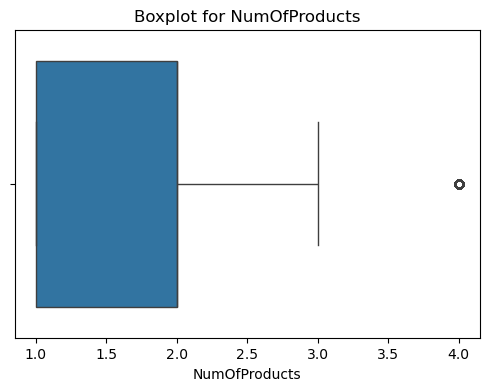

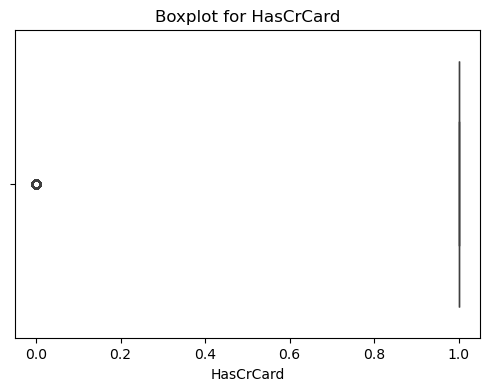

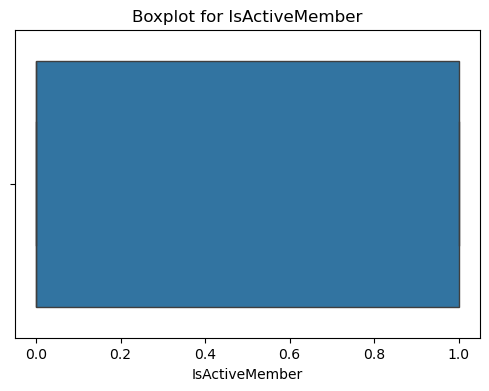

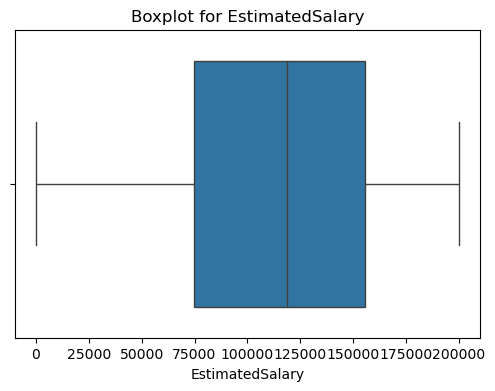

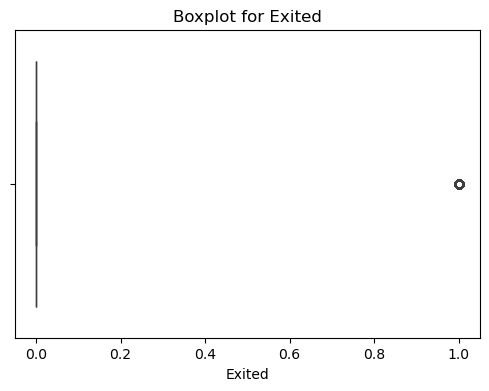

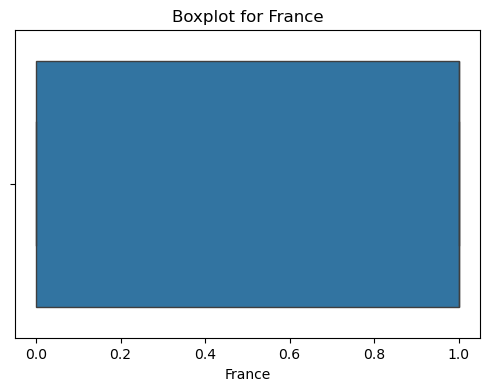

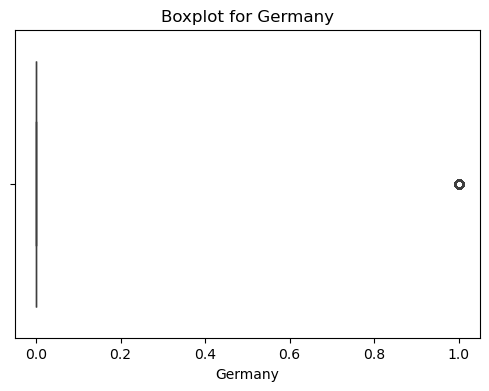

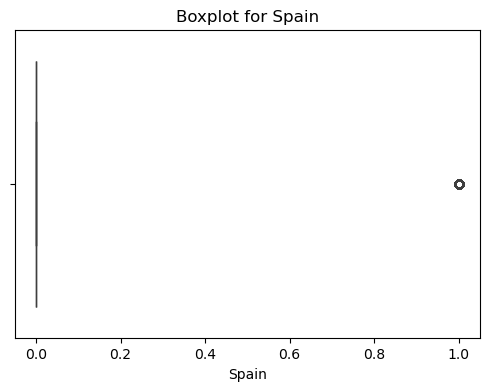

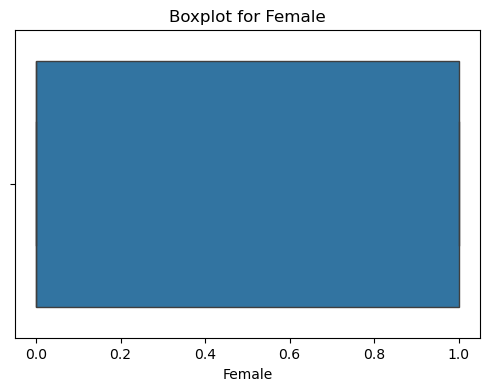

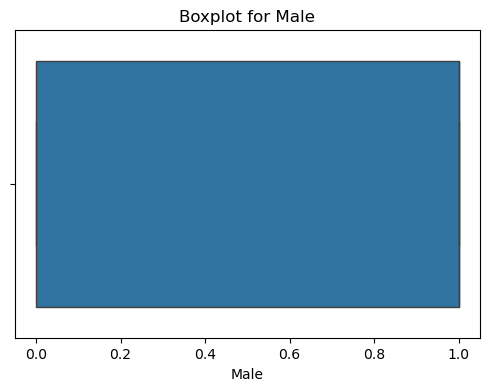

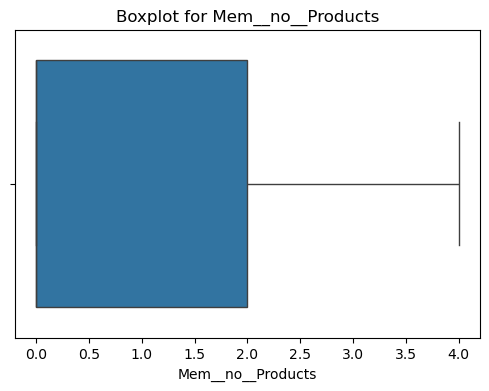

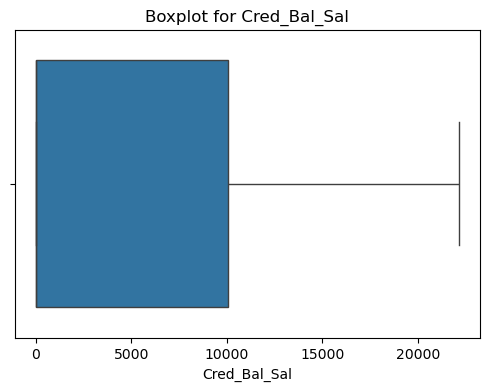

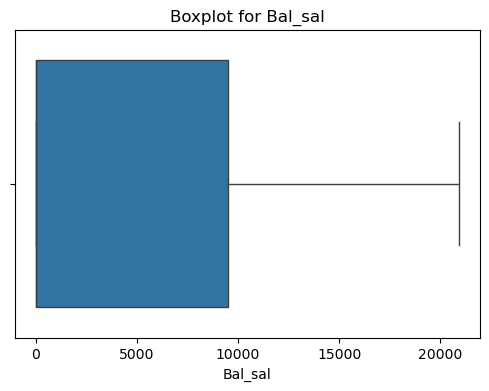

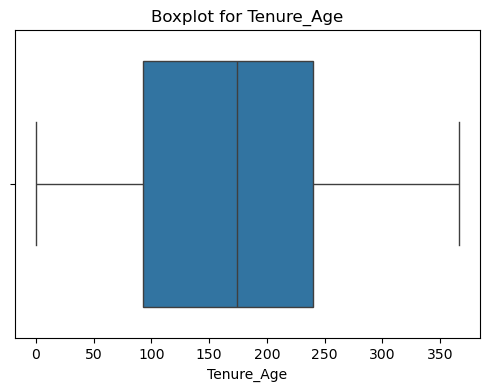

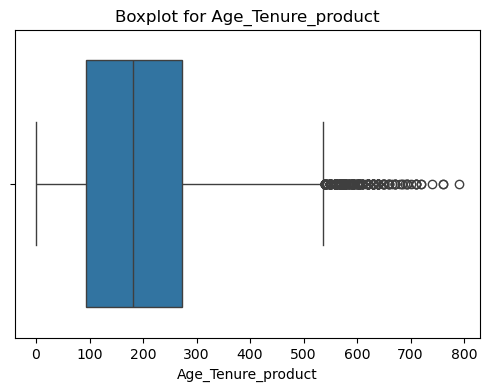

In [25]:
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [13]:
def handle_outliers_clip(data):
    data = data.copy()
    num_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col not in ['Exited']]
    
    for col in num_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    
    return data

data_no_outliers_clip = handle_outliers_clip(data)
print(data_no_outliers_clip['Exited'].value_counts())  

Exited
0    39517
1    10476
Name: count, dtype: int64


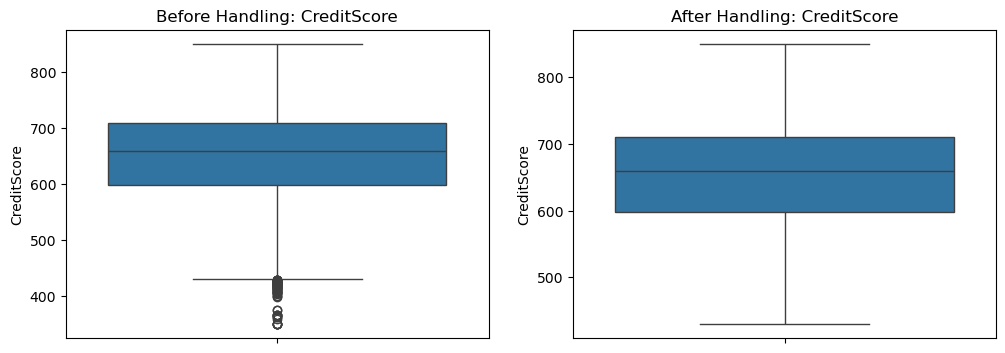

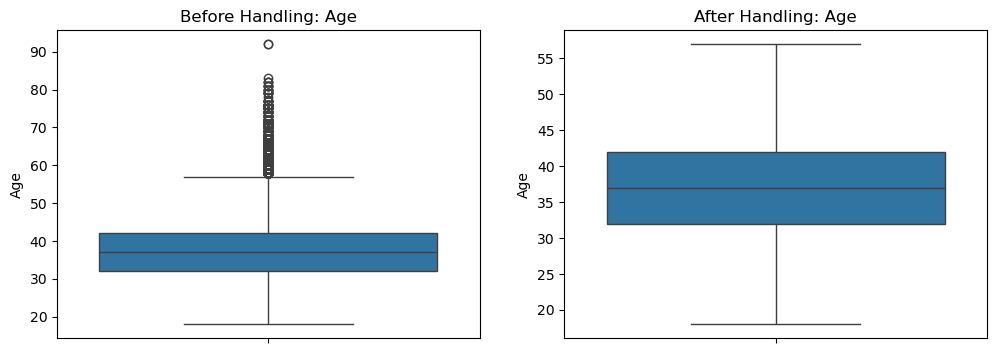

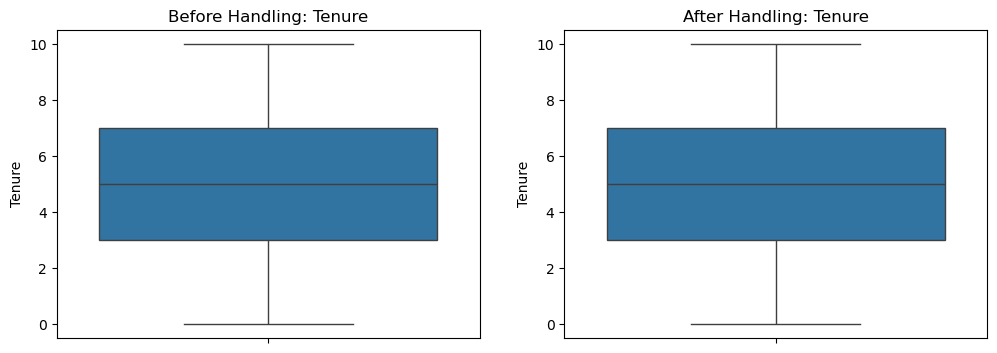

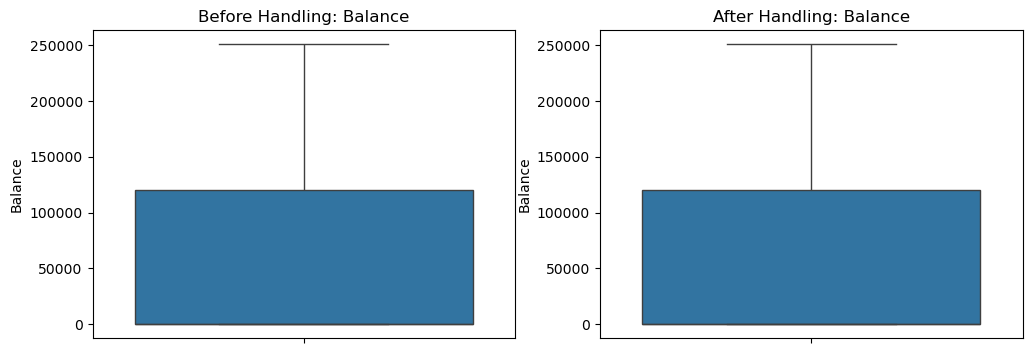

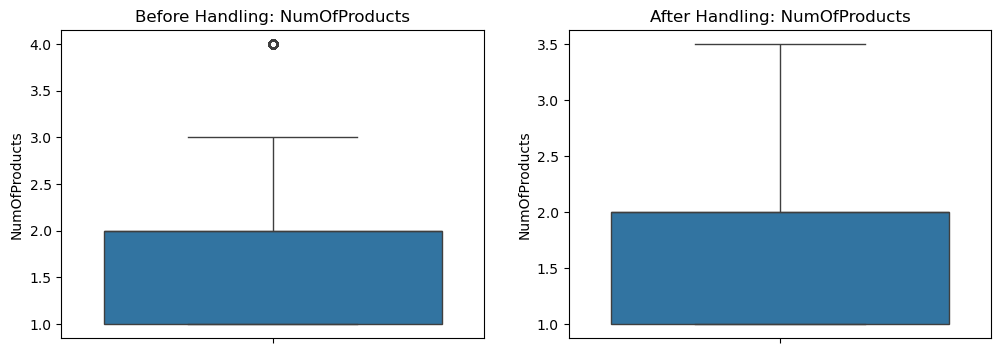

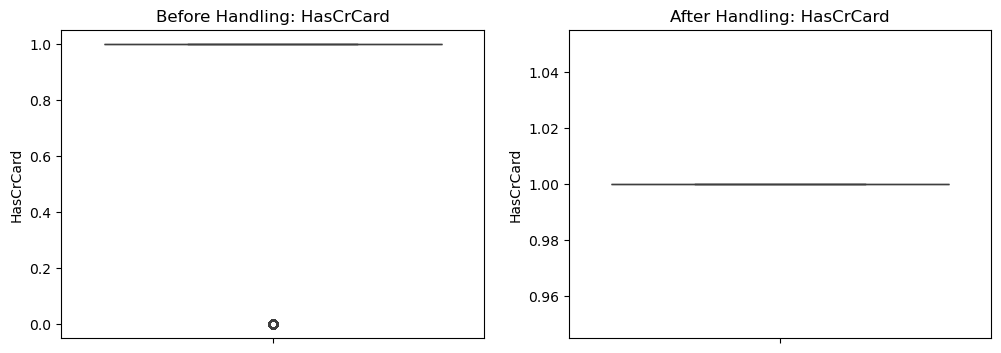

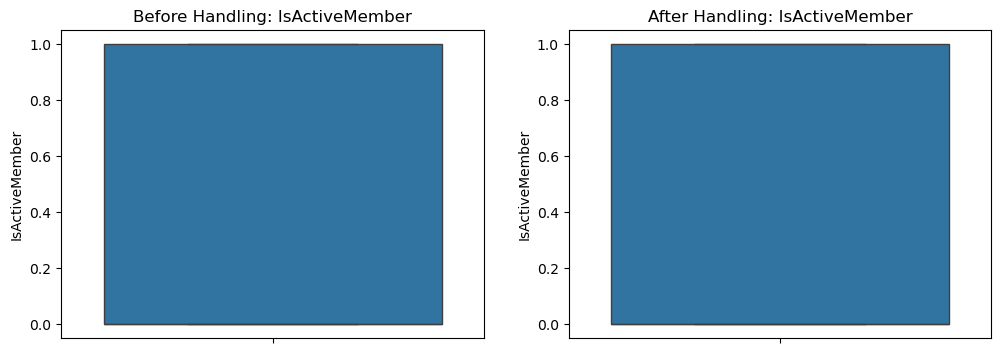

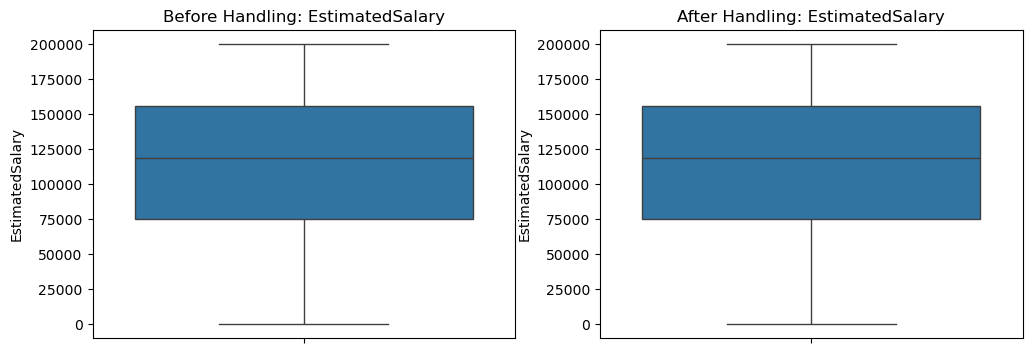

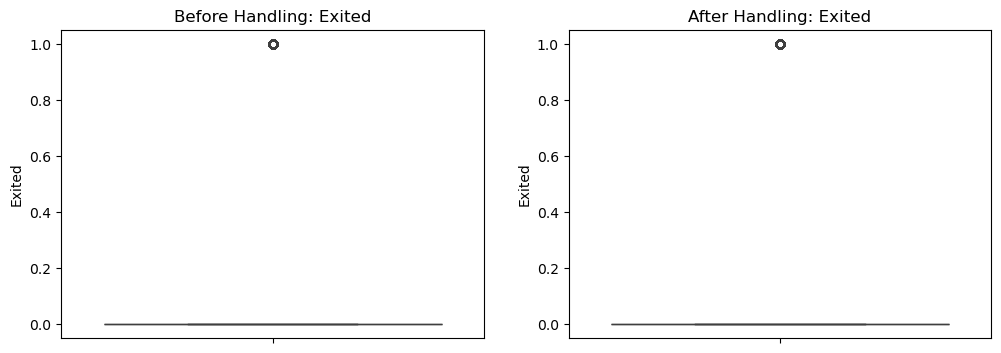

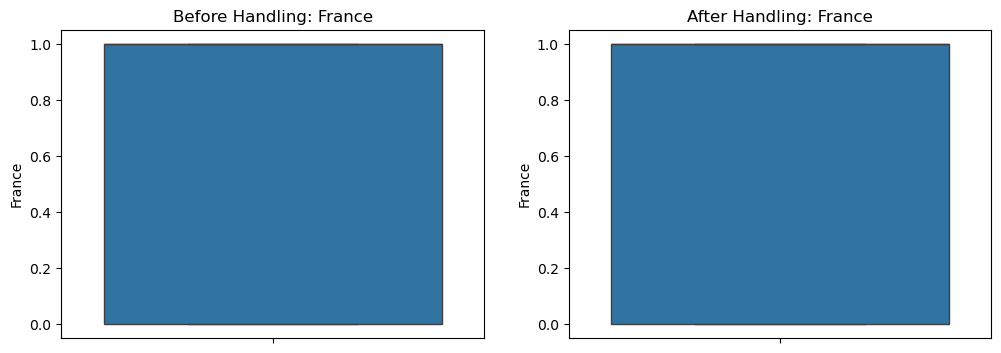

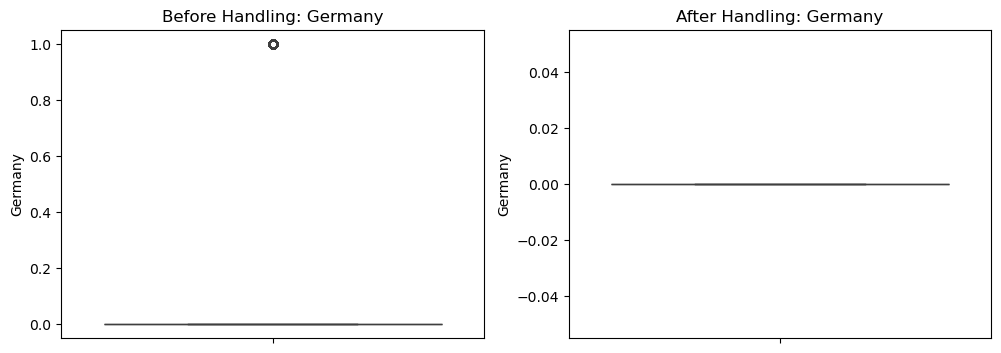

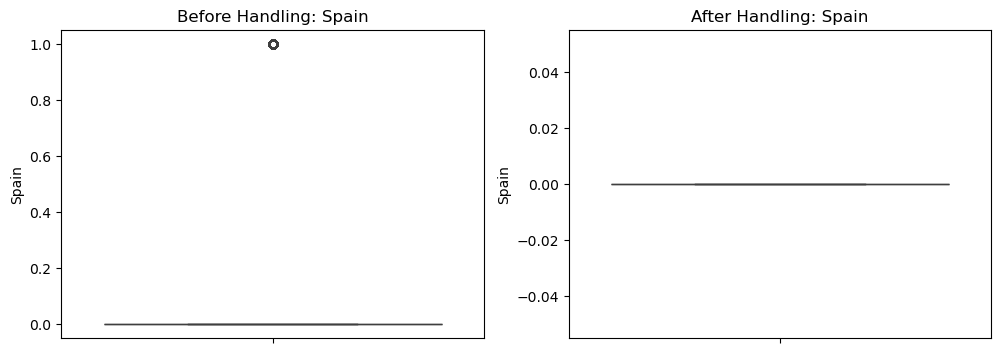

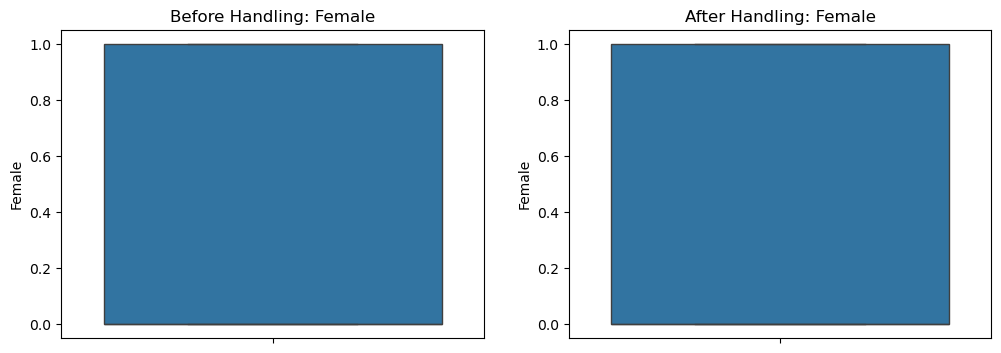

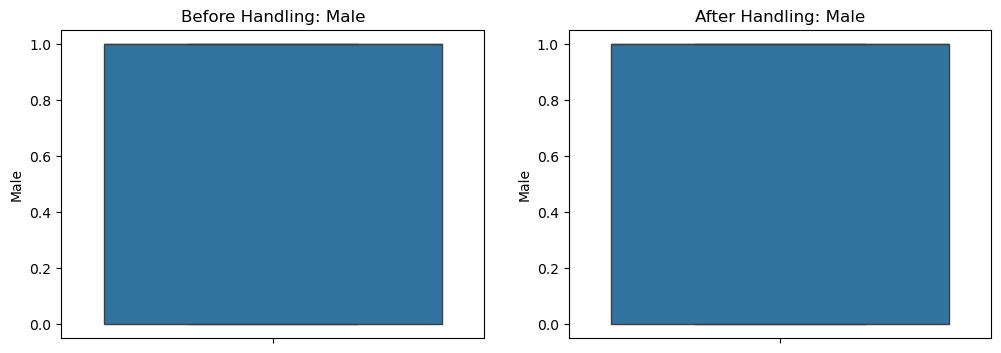

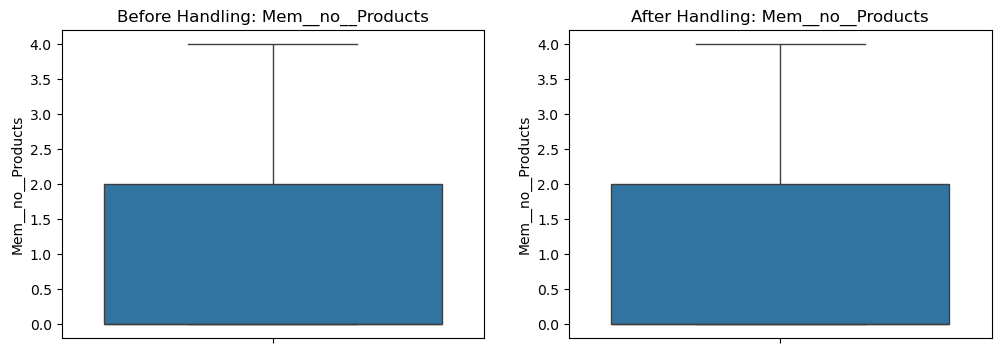

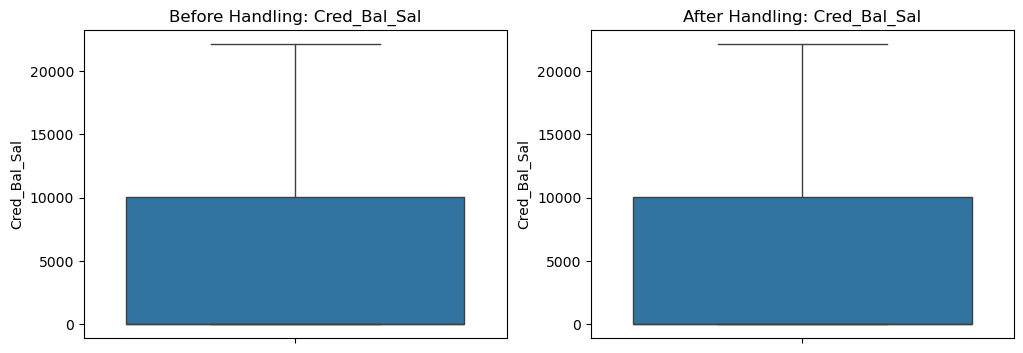

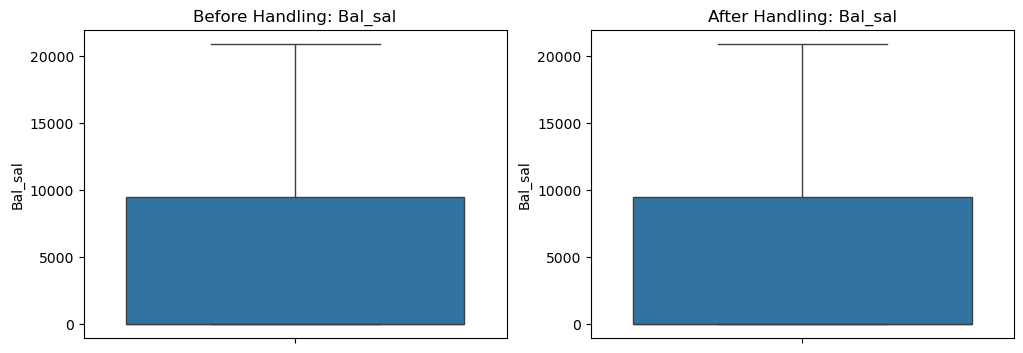

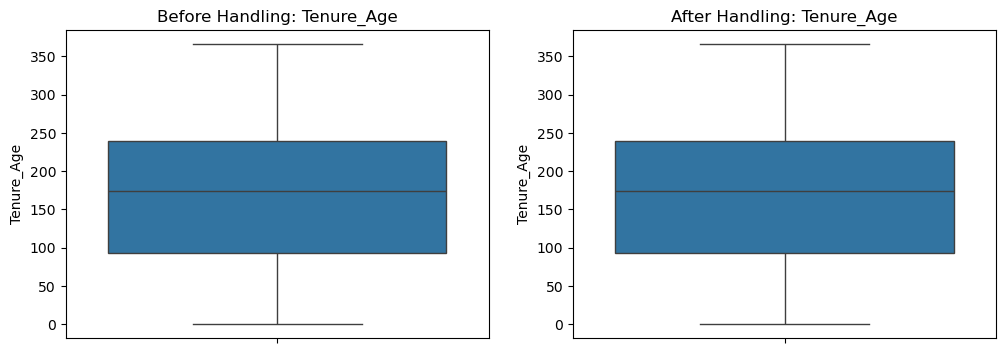

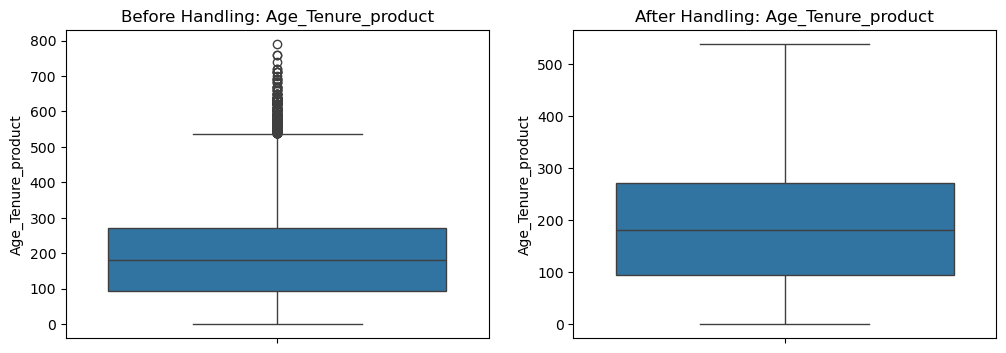

In [29]:
num_cols = data_no_outliers_clip.columns
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.boxplot(y=data[col], ax=axes[0])
    axes[0].set_title(f"Before Handling: {col}")

    sns.boxplot(y=data_no_outliers_clip[col], ax=axes[1])
    axes[1].set_title(f"After Handling: {col}")

    plt.show()


### Exploratory Data Analysis (EDA)

In [17]:
data_no_outliers_clip.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'France', 'Germany',
       'Spain', 'Female', 'Male', 'Mem__no__Products', 'Cred_Bal_Sal',
       'Bal_sal', 'Tenure_Age', 'Age_Tenure_product'],
      dtype='object')

In [31]:
data_no_outliers_clip.shape

(49993, 19)

In [32]:
data_no_outliers_clip.size

949867

In [33]:
data_no_outliers_clip.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
count,49993.000000,49993.000000,49993.000000,49993.000000,49993.000000,49993.0,49993.000000,49993.000000,49993.000000,49993.000000,49993.0,49993.0,49993.000000,49993.000000,49993.000000,49993.000000,49993.000000,49993.000000,49993.000000
mean,656.645550,37.807782,5.027504,55489.607206,1.553818,1.0,0.496810,112747.838464,0.209549,0.573540,0.0,0.0,0.435861,0.564139,0.783870,5069.447903,4770.254356,170.060608,190.555667
std,80.073077,8.172218,2.811229,62773.890075,0.540588,0.0,0.499995,50244.988841,0.406991,0.494567,0.0,0.0,0.495874,0.495874,0.872351,7014.713000,6602.550226,103.067545,116.729156
min,430.000000,18.000000,0.000000,0.000000,1.000000,1.0,0.000000,11.580000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,598.000000,32.000000,3.000000,0.000000,1.000000,1.0,0.000000,74800.990000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,93.000000,94.000000
50%,660.000000,37.000000,5.000000,0.000000,2.000000,1.0,0.000000,118711.750000,0.000000,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,174.000000,182.000000
75%,710.000000,42.000000,7.000000,119839.130000,2.000000,1.0,1.000000,155721.150000,0.000000,1.000000,0.0,0.0,1.000000,1.000000,2.000000,10046.000000,9504.000000,240.000000,272.000000
max,850.000000,57.000000,10.000000,250898.090000,3.500000,1.0,1.000000,199992.480000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,4.000000,22145.000000,20914.000000,366.000000,539.000000


In [34]:
data_no_outliers_clip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49993 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         49993 non-null  float64
 1   Age                 49993 non-null  float64
 2   Tenure              49993 non-null  float64
 3   Balance             49993 non-null  float64
 4   NumOfProducts       49993 non-null  float64
 5   HasCrCard           49993 non-null  float64
 6   IsActiveMember      49993 non-null  float64
 7   EstimatedSalary     49993 non-null  float64
 8   Exited              49993 non-null  int64  
 9   France              49993 non-null  float64
 10  Germany             49993 non-null  float64
 11  Spain               49993 non-null  float64
 12  Female              49993 non-null  float64
 13  Male                49993 non-null  float64
 14  Mem__no__Products   49993 non-null  float64
 15  Cred_Bal_Sal        49993 non-null  float64
 16  Bal_sal  

In [14]:
df=data_no_outliers_clip

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  49993.000000  49993.000000  49993.000000   49993.000000   49993.000000   
mean     656.645550     37.807782      5.027504   55489.607206       1.553818   
std       80.073077      8.172218      2.811229   62773.890075       0.540588   
min      430.000000     18.000000      0.000000       0.000000       1.000000   
25%      598.000000     32.000000      3.000000       0.000000       1.000000   
50%      660.000000     37.000000      5.000000       0.000000       2.000000   
75%      710.000000     42.000000      7.000000  119839.130000       2.000000   
max      850.000000     57.000000     10.000000  250898.090000       3.500000   

       HasCrCard  IsActiveMember  EstimatedSalary        Exited        France  \
count    49993.0    49993.000000     49993.000000  49993.000000  49993.000000   
mean         1.0        0.496810    112747.838464      0.209549      0.573540   
std          0.0        0.4

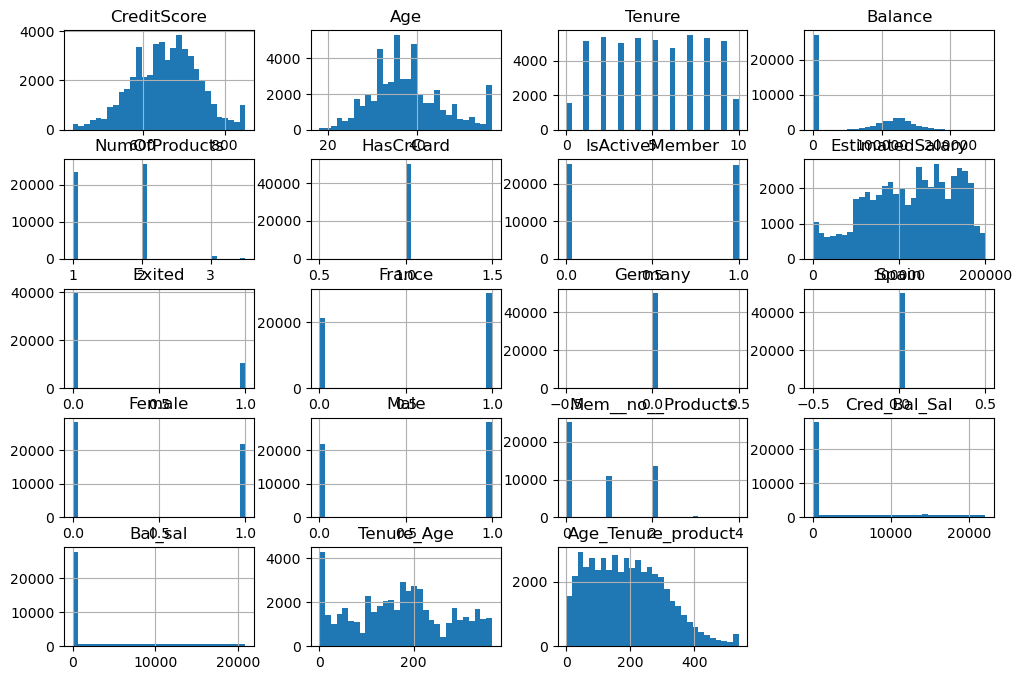

In [37]:
# Summary statistics
print(df.describe())

# Visualize distributions
df.hist(figsize=(12, 8), bins=30)
plt.show()


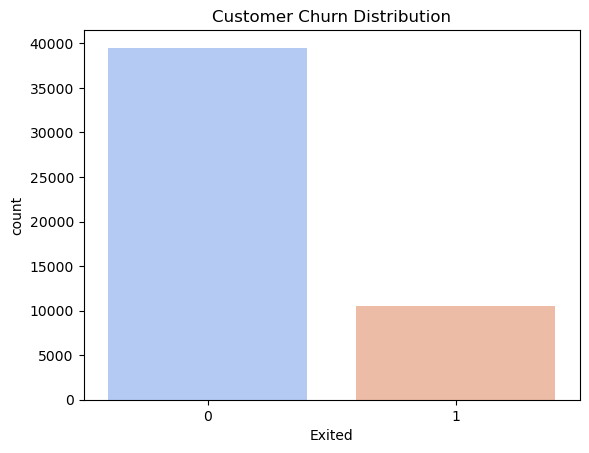

Exited
0    79.045066
1    20.954934
Name: proportion, dtype: float64


In [38]:
#Check Class Imbalance (Target Variable 'Exited')
# Count of churned vs. non-churned customers
sns.countplot(x=df['Exited'], palette="coolwarm")
plt.title("Customer Churn Distribution")
plt.show()

# Print class distribution
print(df['Exited'].value_counts(normalize=True) * 100)


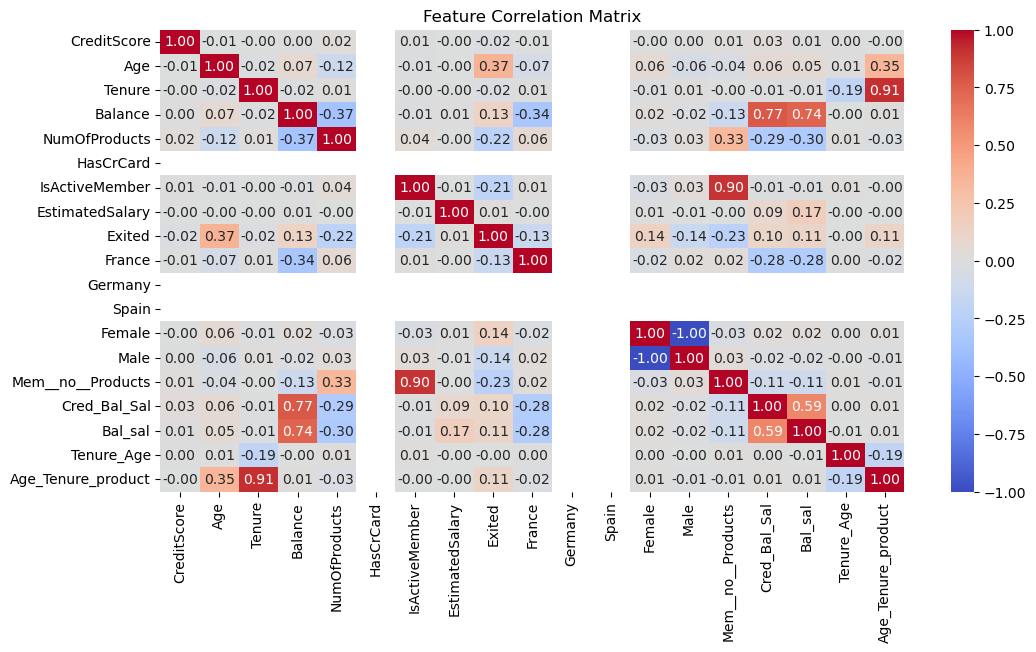

In [39]:
# Compute correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

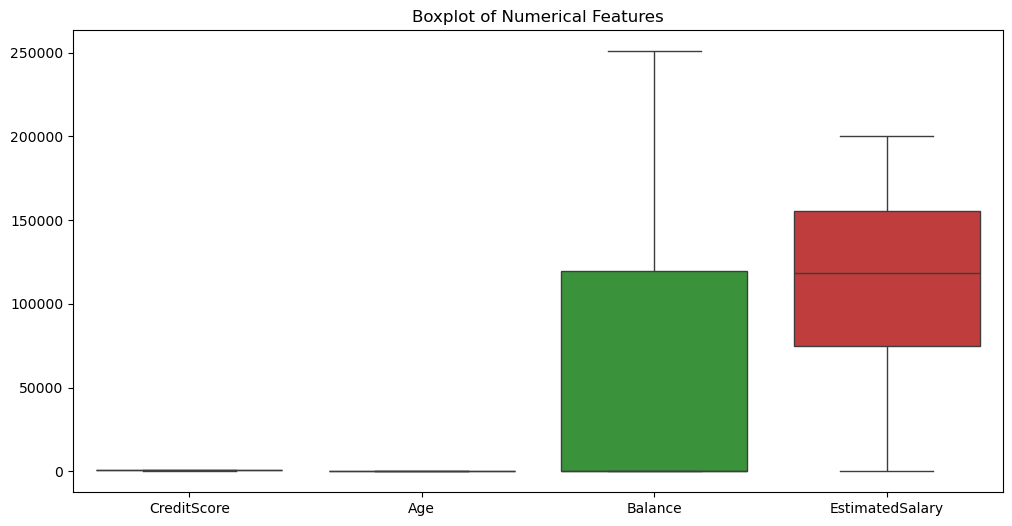

In [40]:
# Check outliers using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']])
plt.title("Boxplot of Numerical Features")
plt.show()

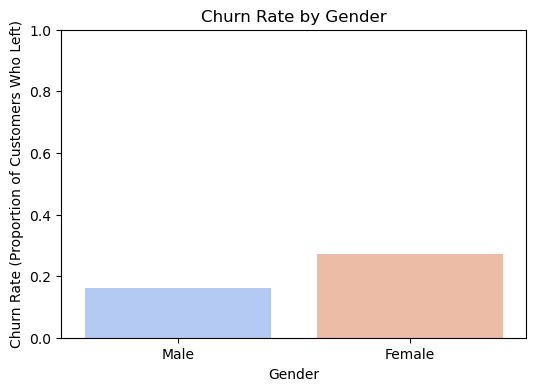

In [41]:
# Churn rate by gender
plt.figure(figsize=(6,4))
sns.barplot(x=['Male', 'Female'], y=df.groupby('Female')['Exited'].mean(), palette="coolwarm")
plt.xlabel("Gender")
plt.ylabel("Churn Rate (Proportion of Customers Who Left)")
plt.title("Churn Rate by Gender")
plt.ylim(0, 1)  # Limit y-axis to 0-1 for better visualization
plt.show()

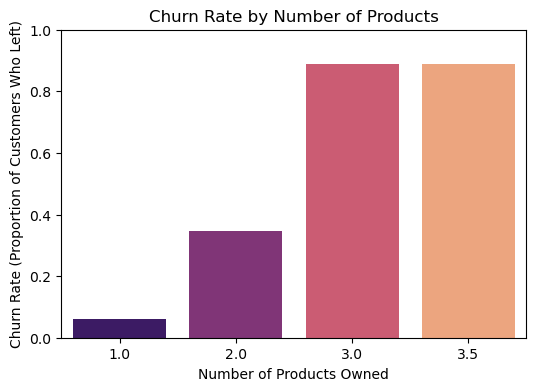

In [42]:
# churn rate by noof products
plt.figure(figsize=(6,4))
sns.barplot(x=df['NumOfProducts'].unique(), 
            y=df.groupby('NumOfProducts')['Exited'].mean(), 
            palette="magma")
plt.xlabel("Number of Products Owned")
plt.ylabel("Churn Rate (Proportion of Customers Who Left)")
plt.title("Churn Rate by Number of Products")
plt.ylim(0, 1)
plt.show()

### Splitting data 

In [15]:
X = df.drop(columns=['Exited'])  

y = df['Exited']  

In [17]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,668.0,33.0,3.0,0.00,2.0,1.0,0.0,181449.97,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,351.0,99.0
1,627.0,33.0,1.0,0.00,2.0,1.0,1.0,49503.50,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,242.0,33.0
2,678.0,40.0,10.0,0.00,2.0,1.0,0.0,184866.69,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0,400.0
3,581.0,34.0,2.0,148882.54,1.0,1.0,1.0,84560.88,1.0,0.0,0.0,0.0,1.0,1.0,1138.0,6961.0,296.0,68.0
4,716.0,33.0,5.0,0.00,2.0,1.0,1.0,15068.83,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,127.0,165.0


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
X_scaled.shape, y.shape

((49993, 18), (49993,))

In [47]:
# Again check the shape of X and y variable
X.shape, y.shape

((49993, 18), (49993,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42,stratify=y)

In [49]:
# Check shape of the splitted variables
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39994, 18), (9999, 18), (39994,), (9999,))

### Initial Modeling

In [18]:
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=47, random_state=34),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42, learning_rate=0.3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=600, learning_rate=0.05, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),    
}

In [51]:
results = []
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)  

    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100

    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

initial_modeling = pd.DataFrame(results)
print("\nInitial Model Performance:")
initial_modeling


Initial Model Performance:


,Model,Train Accuracy,Test Accuracy
0,Random Forest Classifier,99.927489,85.628563
1,Logistic Regression,83.605041,84.148415
2,SVM,83.497525,84.138414
3,KNN,88.273241,84.398440
4,Naive Bayes,80.417063,80.878088
5,Decision Tree,85.347802,85.688569
6,AdaBoost,85.412812,86.228623
7,Gradient Boosting,86.928039,86.888689
8,XGBoost,86.357954,86.878688


### Handling Imbalanced Data

In [18]:
# Check for class imbalance (fraud vs non-fraud)
df['Exited'].value_counts()

Exited
0    39517
1    10476
Name: count, dtype: int64

#### SMOTE (Synthetic Minority Over-sampling Technique)

In [19]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X,Y = smote.fit_resample(X_Scaled,y)
# X,Y = smote.fit_resample(X ,y)

X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.2, random_state=42,stratify=Y)

In [54]:
print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

Train X shape: (63227, 18)
Train y shape: (63227,)
Test X shape: (15807, 18)
Test y shape: (15807,)


In [55]:
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=47, random_state=34),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42, learning_rate=0.3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=600, learning_rate=0.05, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),    
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)   
    y_test_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None  

    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    f1 = f1_score(y_test, y_test_pred)
    auc_roc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else "N/A"
    cm = confusion_matrix(y_test, y_test_pred)

    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'F1-score': f1,
        'AUC-ROC': auc_roc,
        'Confusion Matrix': cm
    })

over_modeling = pd.DataFrame(results)
print("\nModel Performance after Over Sampling:")
over_modeling


Model Performance after Over Sampling:


,Model,Train Accuracy,Test Accuracy,F1-score,AUC-ROC,Confusion Matrix
0,Random Forest Classifier,99.969950,89.827292,0.899412,0.959332,"[[7010, 894], [714, 7189]]"
1,Logistic Regression,74.678539,75.498197,0.753955,0.829862,"[[6000, 1904], [1969, 5934]]"
2,SVM,74.873076,75.631050,0.752155,0.829769,"[[6110, 1794], [2058, 5845]]"
3,KNN,89.684787,85.057253,0.861726,0.921653,"[[6085, 1819], [543, 7360]]"
4,Naive Bayes,73.797586,74.511292,0.751158,0.816234,"[[5697, 2207], [1822, 6081]]"
5,Decision Tree,79.761811,80.160688,0.793684,0.883737,"[[6639, 1265], [1871, 6032]]"
6,AdaBoost,80.112926,80.843930,0.807624,0.889977,"[[6423, 1481], [1547, 6356]]"
7,Gradient Boosting,89.430149,89.745050,0.896110,0.960211,"[[7195, 709], [912, 6991]]"
8,XGBoost,84.229839,84.374012,0.844243,0.924169,"[[6643, 1261], [1209, 6694]]"


### Hyperparameter Tuning

In [22]:
gb_params = {
    'n_estimators': [200, 300],  # Reduce search space
    'learning_rate': [0.01, 0.03],  # Small values prevent overfitting
    'max_depth': [2, 3, 4],  # Prevent deep trees
    'min_samples_split': [20, 30],  # Higher to prevent overfitting
    'min_samples_leaf': [10, 15],  # Higher to ensure generalization
    'subsample': [0.8, 0.9]  # Prevent overfitting by using random data
}

# Initialize Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

# Perform Grid Search
gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=gb_params,
    cv=5,  # 5-Fold Cross-Validation for better generalization
    scoring='accuracy',  # Optimize for accuracy
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search Model
gb_grid.fit(X_train, y_train)

# Get the best model
best_gb = gb_grid.best_estimator_

# Predictions
gb_train_pred = best_gb.predict(X_train)
gb_test_pred = best_gb.predict(X_test)

# Model Performance
gb_train_acc = accuracy_score(y_train, gb_train_pred)
gb_test_acc = accuracy_score(y_test, gb_test_pred)

# Print Results
print("Best GB Parameters:", gb_grid.best_params_)
print("Gradient Boosting - Train Accuracy:", gb_train_acc)
print("Gradient Boosting - Test Accuracy:", gb_test_acc)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best GB Parameters: {'learning_rate': 0.03, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 20, 'n_estimators': 300, 'subsample': 0.9}
Gradient Boosting - Train Accuracy: 0.8751008271782624
Gradient Boosting - Test Accuracy: 0.8747390396659708


In [20]:
gb_model = GradientBoostingClassifier(
    learning_rate=0.03,
    max_depth=4,
    min_samples_leaf=15,
    min_samples_split=20,
    n_estimators=300,
    subsample=0.9,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Gradient Boosting - Train Accuracy: {train_accuracy}")
print(f"Gradient Boosting - Test Accuracy: {test_accuracy}")

print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Gradient Boosting - Train Accuracy: 0.8751008271782624
Gradient Boosting - Test Accuracy: 0.8747390396659708
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      7904
           1       0.88      0.87      0.87      7903

    accuracy                           0.87     15807
   macro avg       0.87      0.87      0.87     15807
weighted avg       0.87      0.87      0.87     15807

Confusion Matrix:
 [[6924  980]
 [1000 6903]]


### Save model

In [21]:
import joblib
joblib.dump(gb_model,'gbmodel.pkl')
joblib.dump(scaler,'X_Scaled.pkl')
joblib.dump(label_encoder,'labelencoder.pkl')

['labelencoder.pkl']

In [82]:
#END